In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as smt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import warnings
import random
import os
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out = pd.read_csv(loc,**kwargs)
    return out


fname=("Local_Area_Unemployment_Statistics__LAUS_.csv","https://drive.google.com/file/d/1xoDHEKiN-y4QyZNET8SdlVRSsgW_7TLy/view?usp=sharing")
data=getfile(fname)
data.head()

local file not found; accessing Google Drive


,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate
0,State,California,01/01/1976,1976,January,N,Final,9672362,8668016,1004346,0.104
1,State,California,01/01/1976,1976,January,Y,Final,9774280,8875685,898595,0.092
2,County,Los Angeles County,01/01/1976,1976,January,N,Final,3364151,3040058,324093,0.096
3,County,Los Angeles County,01/01/1976,1976,January,Y,Final,3381856,3081806,300050,0.089
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,01/01/1976,1976,January,N,Final,3364151,3040058,324093,0.096


In [ ]:
data['Date']= pd.to_datetime(data['Date'])
data['ts'] = data.Date.values.astype(np.int64) # convert datetime to pandas timestamps
data['Employment Rate']=data['Employment ']/data['Labor Force']
data.head()

,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate,ts,Employment Rate
0,State,California,1976-01-01,1976,January,N,Final,9672362,8668016,1004346,0.104,189302400000000000,0.896163
1,State,California,1976-01-01,1976,January,Y,Final,9774280,8875685,898595,0.092,189302400000000000,0.908065
2,County,Los Angeles County,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.096,189302400000000000,0.903663
3,County,Los Angeles County,1976-01-01,1976,January,Y,Final,3381856,3081806,300050,0.089,189302400000000000,0.911277
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.096,189302400000000000,0.903663


In [ ]:
data.columns = ['Area Type', 'Area Name', 'Date', 'Year', 'Month',
       'Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)',
       'Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate','ts','Employment Rate']
subData_County = data.loc[(data['Area Type']=='County')]
subData_State = data.loc[(data['Area Type']=='State')]

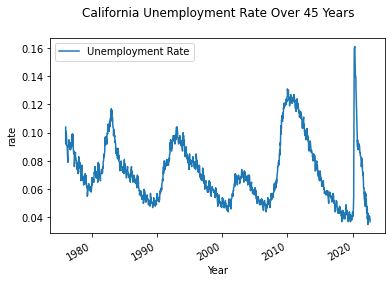

In [ ]:
Pre1 = subData_State[['Date','Unemployment Rate']]
Pre1.set_index(["Date"], inplace=True)
Pre1.plot(title="California Unemployment Rate Over 45 Years\n", ylabel="rate", xlabel="Year")

In [ ]:
subData_State.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122 entries, 0 to 178345
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Area Type                     1122 non-null   object        
 1   Area Name                     1122 non-null   object        
 2   Date                          1122 non-null   datetime64[ns]
 3   Year                          1122 non-null   int64         
 4   Month                         1122 non-null   object        
 5   Seasonally Adjusted (Y/N)     1122 non-null   object        
 6   Status (Preliminary / Final)  1122 non-null   object        
 7   Labor Force                   1122 non-null   int64         
 8   Employment                    1122 non-null   int64         
 9   Unemployment                  1122 non-null   int64         
 10  Unemployment Rate             1122 non-null   float64       
 11  ts                          

In [ ]:
Pre1.head()

,Unemployment Rate
Date,
1976-01-01,0.104
1976-01-01,0.092
1977-01-01,0.099
1977-01-01,0.092
1978-01-01,0.083


In [ ]:
df = Pre1.reset_index()['Unemployment Rate']
df.head()

0    0.104
1    0.092
2    0.099
3    0.092
4    0.083
Name: Unemployment Rate, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
print(df1)

[[0.54761905]
 [0.45238095]
 [0.50793651]
 ...
 [0.45238095]
 [0.1031746 ]
 [0.18253968]]


In [ ]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(729, 393)

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train.shape, y_train.shape

((628, 100), (628,))

In [ ]:
X_test.shape, ytest.shape

((292, 100), (292,))

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=45,batch_size=16,verbose=1)

Epoch 1/45
40/40 [==============================] - 6s 141ms/step - loss: 0.0143 - val_loss: 0.0088
Epoch 2/45
40/40 [==============================] - 6s 138ms/step - loss: 0.0136 - val_loss: 0.0140
Epoch 3/45
40/40 [==============================] - 6s 140ms/step - loss: 0.0120 - val_loss: 0.0070
Epoch 4/45
40/40 [==============================] - 6s 140ms/step - loss: 0.0103 - val_loss: 0.0091
Epoch 5/45
40/40 [==============================] - 6s 140ms/step - loss: 0.0133 - val_loss: 0.0073
Epoch 6/45
40/40 [==============================] - 5s 137ms/step - loss: 0.0108 - val_loss: 0.0065
Epoch 7/45
40/40 [==============================] - 6s 138ms/step - loss: 0.0090 - val_loss: 0.0069
Epoch 8/45
40/40 [==============================] - 6s 139ms/step - loss: 0.0093 - val_loss: 0.0080
Epoch 9/45
40/40 [==============================] - 6s 143ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 10/45
40/40 [==============================] - 7s 162ms/step - loss: 0.0105 - val_loss: 0.0066

In [ ]:
import tensorflow as tf

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

10/10 [==============================] - 0s 37ms/step


In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)


In [ ]:
ytest = scaler.inverse_transform(np.array(ytest).reshape(-1,1))

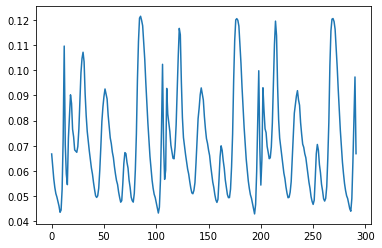

In [ ]:
plt.plot(test_predict)

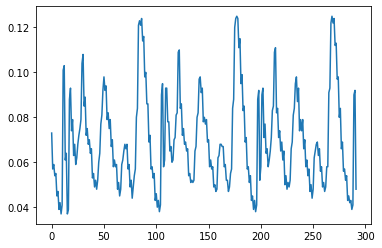

In [ ]:
plt.plot(ytest)

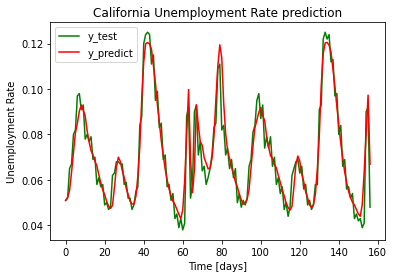

In [ ]:
plt.plot(ytest[135:], label="y_test", color='green')
plt.plot(test_predict[135:], label="y_predict", color='red')
 
plt.title('California Unemployment Rate prediction')
plt.xlabel('Time [days]')
plt.ylabel('Unemployment Rate')
plt.legend(loc='best')
 
plt.show();

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.28047989150894836

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.007603404787673781

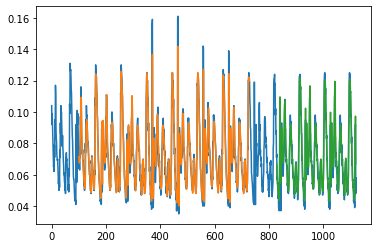

In [ ]:
### Plotting 
# shift train predictions for plotting
import numpy
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()